In [1]:
import os
import time
import sys
import json
from datetime import datetime
sys.path.append("/global/homes/s/seanjx/gigalens/src")

from gigalens.jax.inference import ModellingSequence
from gigalens.jax.model import ForwardProbModel, BackwardProbModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.model import PhysicalModel

import tensorflow_probability.substrates.jax as tfp

import jax
from jax import random
from jax import numpy as jnp

import numpy as np
import optax
from matplotlib import pyplot as plt

from astropy.io import fits
from astropy.visualization import simple_norm

import myfunctions
from myfunctions import printToFile

from corner import corner

tfd = tfp.distributions

/global/common/software/deepsrch/jax_gigalens_kernel/jax-gigalens/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#create output directory
now = str(datetime.now())
#now = "2024-06-20 12:03:01.477412"

path = "output/"+now+"/"
os.makedirs(path)

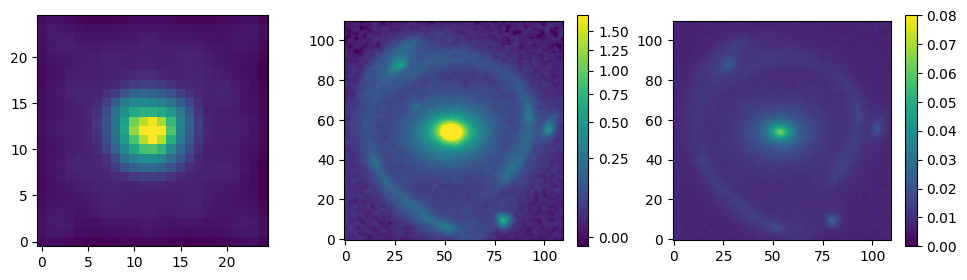

In [3]:
#load observation data, do masking
f=fits.open('psf2.fits') 
psf=jnp.array(f[0].data)

observed_img = np.load("cutout.npy")

background_rms=0.0075455
exp_time=1197

err_map = np.sqrt(background_rms**2 + observed_img/exp_time)
threshold_lens=1.
error_masked=err_map
#error_masked[45:65,45:65]=np.where(observed_img[45:65,45:65]>threshold_lens, 120000, error_masked[45:65,45:65]) #mask the lens
#error_masked[5:15,75:85]=np.where(observed_img[5:15,75:85]>0.3, 120000, error_masked[5:15,75:85])

plt.figure(figsize=(12,3))
norm = simple_norm(psf, 'sqrt', percent=99.)
plt.subplot(131)
plt.imshow(psf, norm=norm, origin='lower', cmap='viridis')


norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.subplot(132)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

plt.subplot(133)
plt.imshow(err_map, vmin=0,vmax=0.08, origin='lower')
plt.colorbar()

In [4]:
prior, phys_model, phys_model_Forward = myfunctions.readJson("prior.json")
deltaPix = 0.065
numPix = np.shape(observed_img)[0]
sim_config = SimulatorConfig(delta_pix=deltaPix, num_pix=numPix, supersample=1, kernel=psf)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

prob_model = BackwardProbModel(prior, observed_img, error_masked, background_rms=0.0075455	, exp_time=1197)
model_seq = ModellingSequence(phys_model, prob_model, sim_config)

In [5]:
print(myfunctions.countParameters(phys_model),myfunctions.getPriors(phys_model))

44 (['EPL', 'SHEAR'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'], ['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE'])


In [6]:
start = time.perf_counter()

n_samples_bs = 2000
schedule_fn = optax.polynomial_schedule(init_value=-1e-2, end_value=-1e-4, 
                                      power=0.5, transition_steps=1000)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)

map_estimate, chi = model_seq.MAP(opt, n_samples=n_samples_bs,num_steps=1000,seed=0)
end = time.perf_counter()
MAPtime = end - start
print(MAPtime)

Chi-squared: 1.891: 100%|██████████| 1000/1000 [02:38<00:00,  6.31it/s] 

160.44132758001797


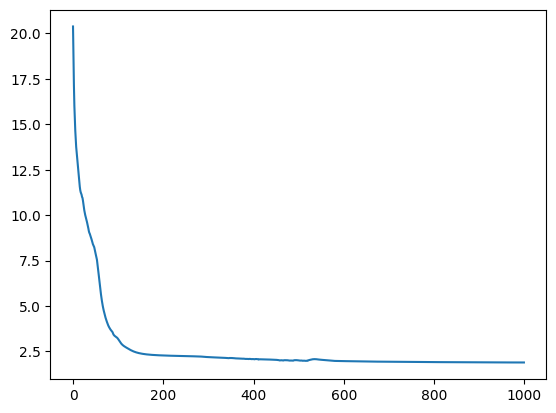

In [9]:
plt.style.use("default")
np.save(path+"/map.npy",map_estimate)
plt.plot(np.array(chi))
plt.savefig(path+"/chi-squared.png")

In [ ]:
start = time.perf_counter()

map_estimate=np.load(path+"/map.npy")

try:
    lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=n_samples_bs), map_estimate)[0]
    best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]
except:
    map_estimate=np.load(path+"/map.npy")
    lps = prob_model.log_prob(LensSimulator(phys_model, sim_config, bs=n_samples_bs), map_estimate)[0]
    best = map_estimate[jnp.nanargmax(lps)][jnp.newaxis,:]

end = time.perf_counter()
logProbTime = end-start
print(logProbTime)

In [23]:
np.save(path+"/best.npy",best)

2.3745754


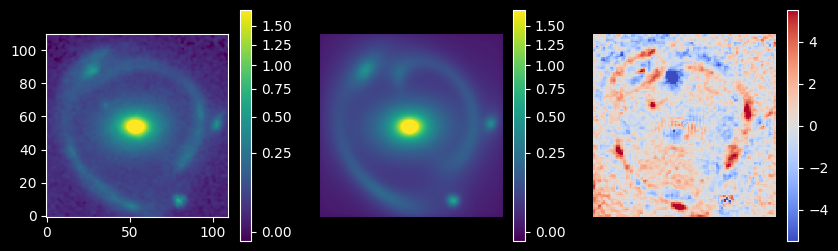

In [26]:
params = prob_model.bij.forward(best.tolist()[0])

plt.figure(figsize=(10, 3))

plt.subplot(131)
norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

simulated = lens_sim.lstsq_simulate(params,jnp.array(observed_img),err_map)[0]

plt.subplot(132)
plt.imshow(simulated, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = jnp.array(observed_img) - simulated
background_rms, exp_time = 0.0075455, 1197
plt.imshow(resid/err_map, cmap='coolwarm', origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)


MAPchi = np.mean((resid/err_map)**2)
plt.axis('off')
plt.colorbar()

print(MAPchi)
#plt.savefig(path+"/output.png")

ELBO: nan: 100%|██████████| 10000/10000 [10:19<00:00, 16.15it/s]      


621.2075914259767


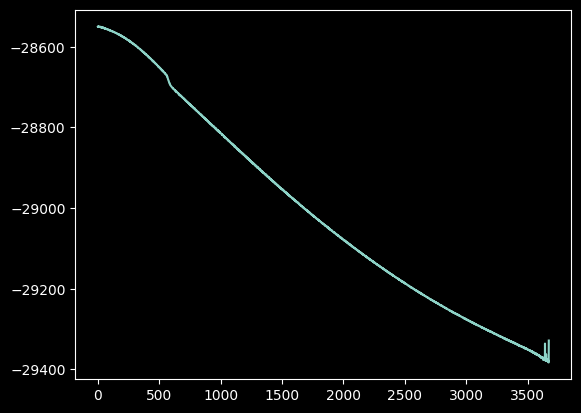

In [27]:
start = time.perf_counter()
steps=2000

schedule_fn = optax.polynomial_schedule(init_value=0, end_value=-5e-4, 
                                      power=2, transition_steps=steps/2)
opt = optax.chain(
  optax.scale_by_adam(),
  optax.scale_by_schedule(schedule_fn),
)
qz, loss_hist = model_seq.SVI(best, opt, n_vi=1000, num_steps=steps)

end = time.perf_counter()
SVItime = end-start

plt.plot(loss_hist)
np.save(path+"/SVI.npy",qz)
print(SVItime)

In [ ]:
mean=qz.mean()
cov=qz.covariance()
scale = np.linalg.cholesky(cov)

In [ ]:
start = time.perf_counter()
samples = model_seq.HMC(qz, num_burnin_steps=250, num_results=750)
end = time.perf_counter()

HMCtime = end-start
np.save(path+"/HMC.npy",samples)
print(HMCtime)

In [13]:
rhat= tfp.mcmc.potential_scale_reduction(jnp.transpose(samples.all_states, (1,2,0,3)), independent_chain_ndims=2)
print(rhat)

[ 3.1852639  8.652713   7.5517697  5.269884   7.934984   4.9318814
  3.067962   6.7147145  3.816279   2.6267638  2.1241016  9.487772
  7.7559395  3.5853727  9.200176   2.6689181  4.0109515  4.2040644
  3.5890558  2.8941467  7.0122766  5.2161036  2.2319236  7.49183
  8.057164   7.224675  11.601138   2.5277934  2.355542   3.0743988
  2.0587296  7.1014757  2.3121538  5.4647317  6.2819943  3.9881418
  6.8492413  2.7631764  5.9382753  3.6000178  4.973433  10.431316
  6.900229   2.2745645]


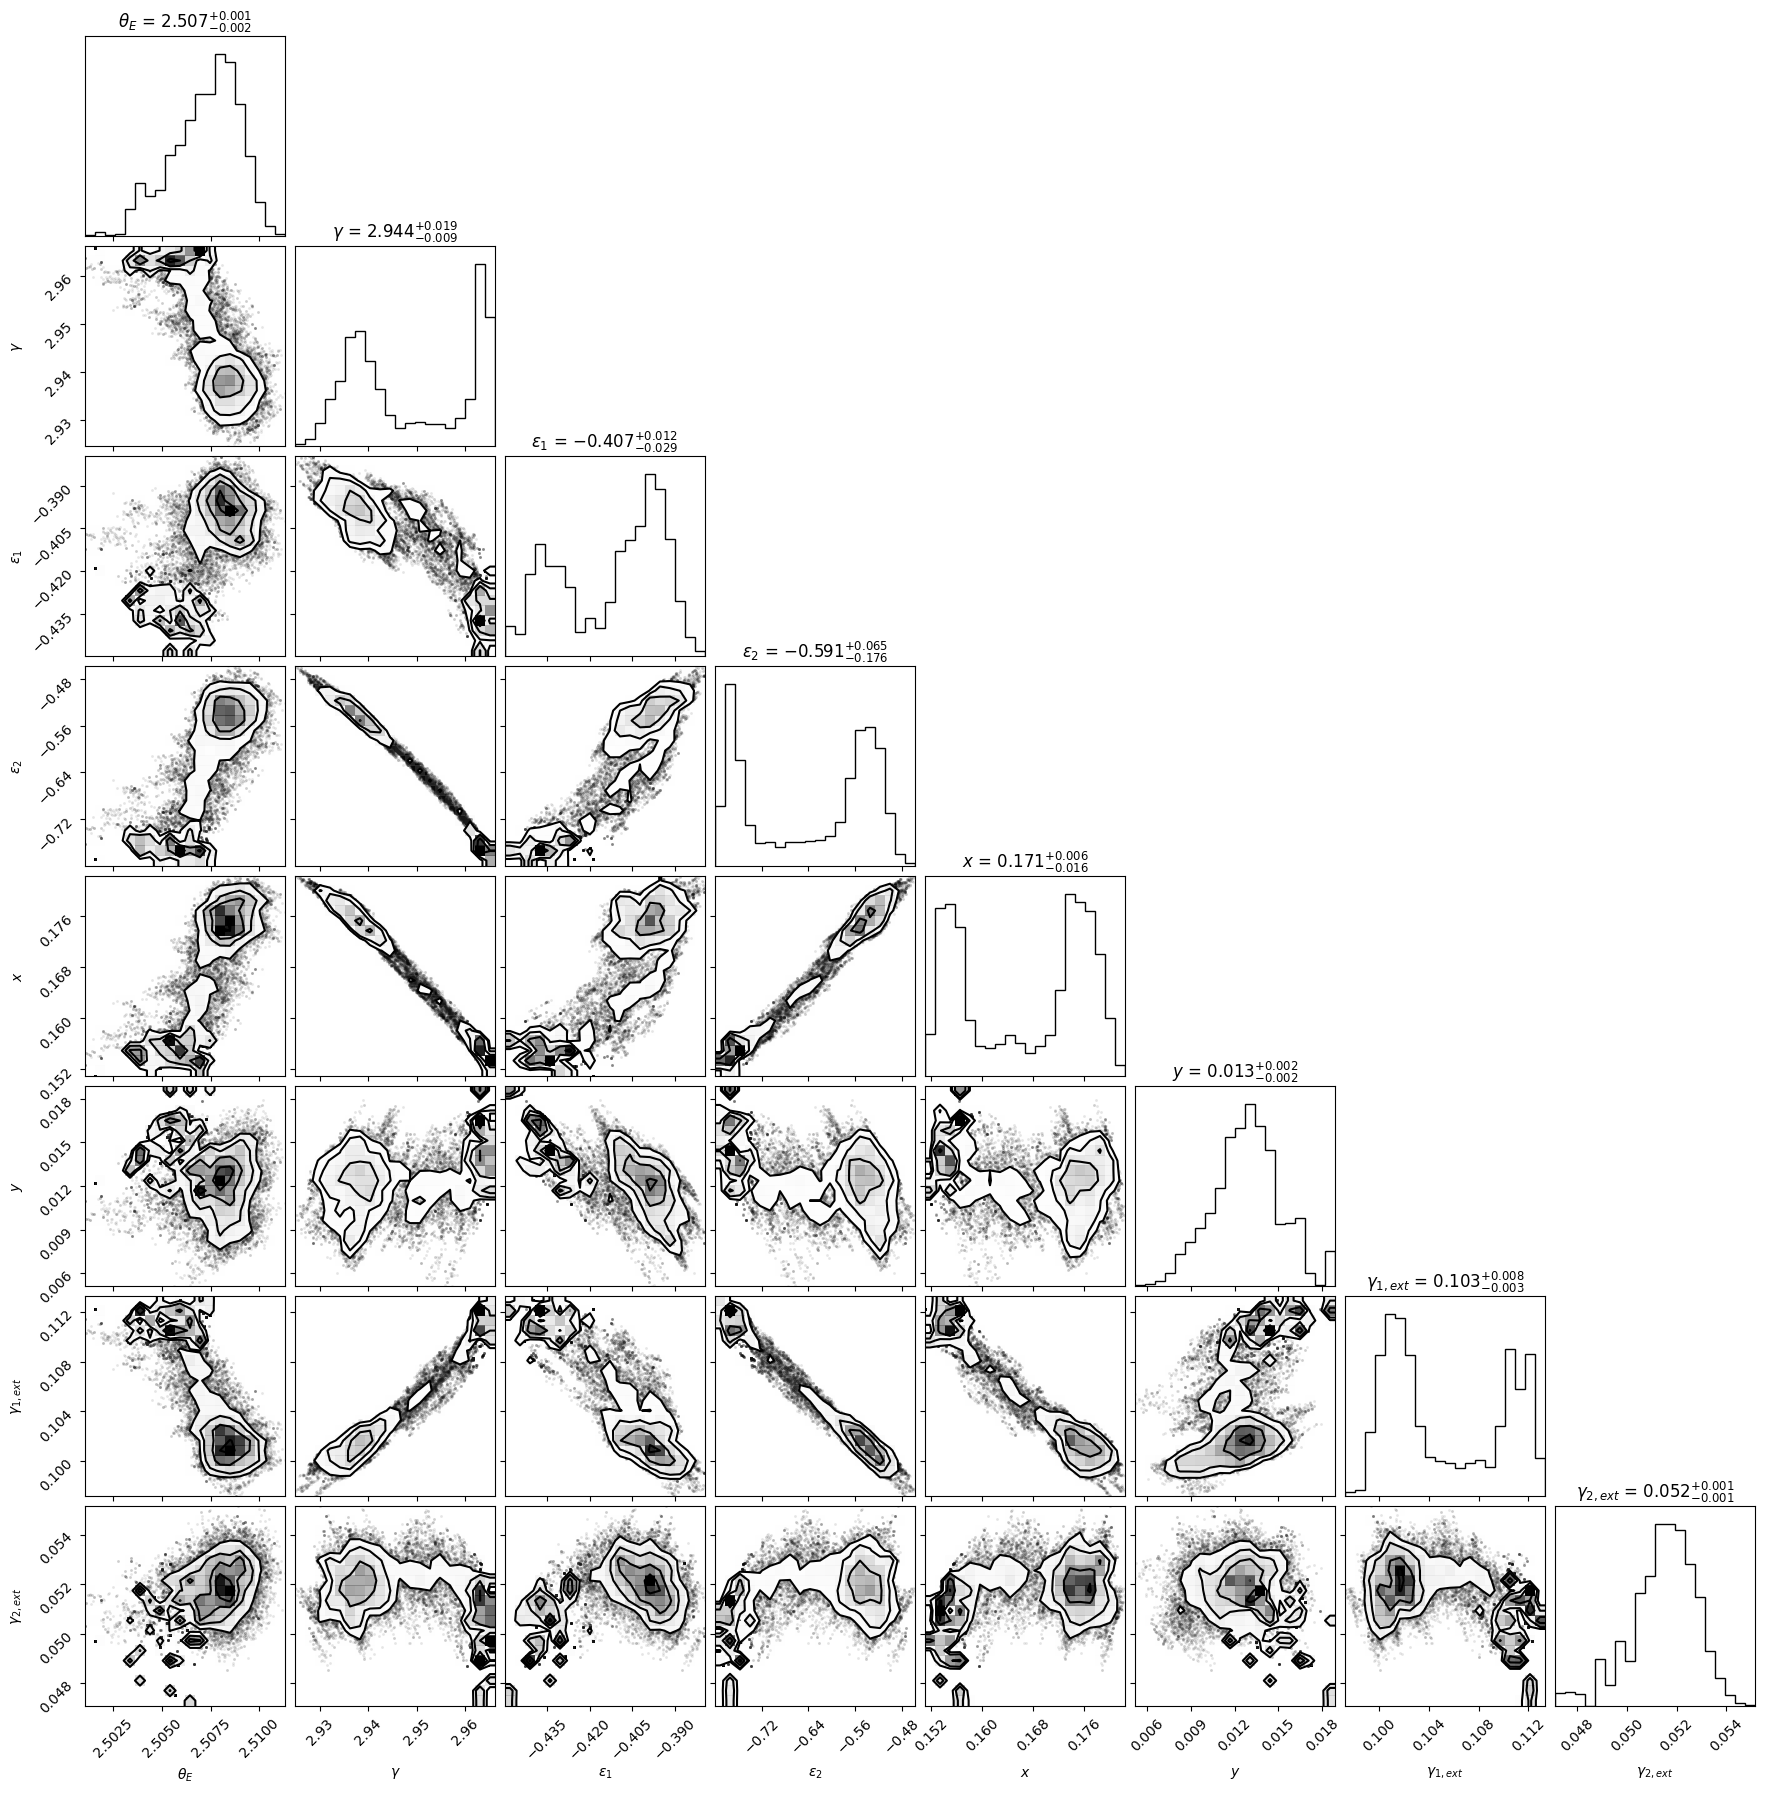

In [14]:
smp = jnp.transpose(samples.all_states, (1,2,0,3)).reshape((-1, myfunctions.countParameters(phys_model)))
smp_physical = prob_model.bij.forward(list(smp.T))

# stack = []
# reversedStack = []
# for ii, profileset in enumerate(phys_model.getProfiles()):
#     for iii, profile in enumerate(profileset):
#         tempStack = []
#         for parameter in profile._params:
#             if parameter != "amp":
#                 tempStack.append(smp_physical[ii][iii][parameter])
#                 print(parameter)
#         stack.extend(tempStack)
#         reversedStack.extend(reversed(tempStack))
                
# physical_samples = np.column_stack(stack)
# reversed_physical_samples = np.column_stack(reversedStack)


get_samples = np.column_stack((
                                smp_physical[0][0]["center_x"],
                                smp_physical[0][0]["center_y"],
                                smp_physical[0][0]["e1"],
                                smp_physical[0][0]["e2"],
                                smp_physical[0][0]["gamma"],
                                smp_physical[0][0]["theta_E"],
    
                                smp_physical[0][1]["gamma1"],
                                smp_physical[0][1]["gamma2"],
    
                                smp_physical[1][0]["R_sersic"],
                                smp_physical[1][0]["center_x"],
                                smp_physical[1][0]["center_y"],
                                smp_physical[1][0]["e1"],
                                smp_physical[1][0]["e2"],
                                smp_physical[1][0]["n_sersic"],
    
                                smp_physical[1][1]["R_sersic"],
                                smp_physical[1][1]["center_x"],
                                smp_physical[1][1]["center_y"],
                                smp_physical[1][1]["e1"],
                                smp_physical[1][1]["e2"],
                                smp_physical[1][1]["n_sersic"],
    
                                smp_physical[1][2]["R_sersic"],
                                smp_physical[1][2]["center_x"],
                                smp_physical[1][2]["center_y"],
                                smp_physical[1][2]["e1"],
                                smp_physical[1][2]["e2"],
                                smp_physical[1][2]["n_sersic"],

                                smp_physical[1][3]["R_sersic"],
                                smp_physical[1][3]["center_x"],
                                smp_physical[1][3]["center_y"],
                                smp_physical[1][3]["e1"],
                                smp_physical[1][3]["e2"],
                                smp_physical[1][3]["n_sersic"],
    
                                smp_physical[2][0]["R_sersic"],
                                smp_physical[2][0]["center_x"],
                                smp_physical[2][0]["center_y"],
                                smp_physical[2][0]["e1"],
                                smp_physical[2][0]["e2"],
                                smp_physical[2][0]["n_sersic"],
    
                                # smp_physical[2][1]["R_sersic"],
                                # smp_physical[2][1]["center_x"],
                                # smp_physical[2][1]["center_y"],
                                # smp_physical[2][1]["e1"],
                                # smp_physical[2][1]["e2"],
                                # smp_physical[2][1]["n_sersic"], 
                                ))
physical_samples = get_samples

reversed_physical_samples = np.zeros([36000,8])
reversed_physical_samples[:,0:6]=np.flip(physical_samples[:,0:6])
reversed_physical_samples[:,6:8]=np.flip(physical_samples[:,6:8])

best_HMC=prob_model.pack_bij.forward(np.median(physical_samples,axis=0).tolist())

plt.style.use('default')
corner(reversed_physical_samples[:,0:8], show_titles=True, title_fmt='.3f', 
                            labels=[r'$\theta_E$', r'$\gamma$', r'$\epsilon_1$', r'$\epsilon_2$', r'$x$', r'$y$', r'$\gamma_{1,ext}$', r'$\gamma_{2,ext}$']);

1.9016446
done


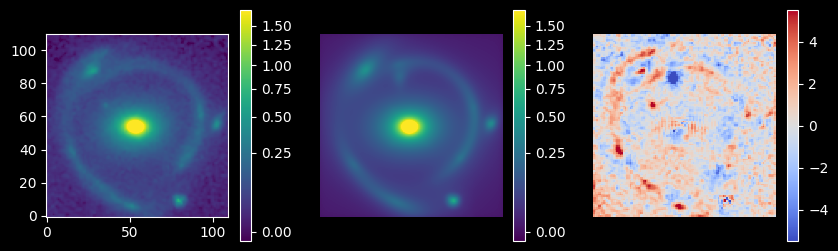

In [15]:
plt.style.use('dark_background')

plt.figure(figsize=(10, 3))

plt.subplot(131)
norm = simple_norm(observed_img, 'sqrt', percent=99.)
plt.imshow(observed_img, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

simulated = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)[0]

plt.subplot(132)
plt.imshow(simulated, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()
plt.axis('off')

plt.subplot(133)
resid = jnp.array(observed_img) - simulated
background_rms, exp_time = 0.0075455, 1197
plt.imshow(resid/err_map, cmap='coolwarm', origin='lower',interpolation='none', vmin=-5.5, vmax=5.5)

HMCchi = np.mean((resid/err_map)**2)

print(HMCchi)
plt.axis('off')
plt.colorbar()

plt.savefig(path+"/output.png")
print("done")

19.584007 630.27576


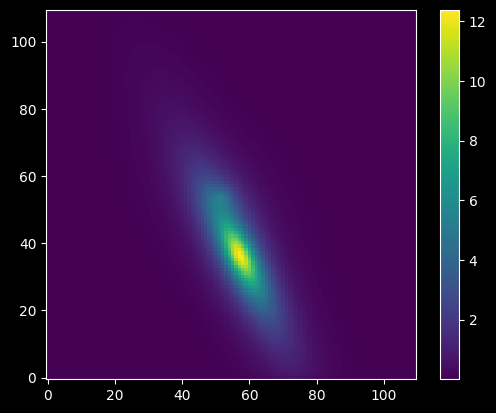

In [25]:
source_sim = LensSimulator(phys_model, sim_config, bs=1)

coeffs = lens_sim.lstsq_simulate(best_HMC,jnp.array(observed_img),err_map)[1]

Ie1=coeffs[0][2]*1/deltaPix**2
Ie2=coeffs[0][3]*1/deltaPix**2
#Ies
print(Ie1, Ie2)
source_light_dict_ser1= {'R_sersic': best_HMC[2][0]['R_sersic'], 'n_sersic': best_HMC[2][0]['n_sersic'], 'e1': best_HMC[2][0]['e1'], 'e2': best_HMC[2][0]['e2'], 'center_x': best_HMC[2][0]['center_x'], 'center_y': best_HMC[2][0]['center_y'],'Ie': Ie1}
source_light_dict_ser2= {'R_sersic': best_HMC[2][1]['R_sersic'], 'n_sersic': best_HMC[2][1]['n_sersic'], 'e1': best_HMC[2][1]['e1'], 'e2': best_HMC[2][1]['e2'], 'center_x': best_HMC[2][1]['center_x'], 'center_y': best_HMC[2][1]['center_y'],'Ie': Ie2}

truth = [[], [], [source_light_dict_ser1,source_light_dict_ser2]]

lens_sim_Source = LensSimulator(phys_model_Forward, sim_config, bs=1)
sourcesimulated = lens_sim_Source.simulate(truth)
plt.imshow(sourcesimulated, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [ ]:
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.Plots import lens_plot
import lenstronomy.Util.simulation_util as sim_util
from lenstronomy.Data.imaging_data import ImageData
kwargs_data = sim_util.data_configure_simple(numPix*2, deltaPix)
data = ImageData(**kwargs_data)
_coords = data
lens_model_list = ['EPL',
                   'SHEAR',
                    ]
lensModel = LensModel(lens_model_list=lens_model_list)
kwargs_main_lens = {
    'theta_E': best_HMC[0][0]['theta_E'],
    'gamma': best_HMC[0][0]['gamma'],
     'e1': best_HMC[0][0]['e1'],
      'e2': best_HMC[0][0]['e2'],
       'center_x': best_HMC[0][0]['center_x'],
        'center_y': best_HMC[0][0]['center_y'],
        } #Main lens
kwargs_shear = {
    'gamma1': best_HMC[0][1]['gamma1'],
     'gamma2': best_HMC[0][1]['gamma2'],
     }  #External shear
kwargs_lens = [kwargs_main_lens,
               kwargs_shear,
               ]

modeled_img = lens_sim.lstsq_simulate(best_HMC,imR,err_map)
residual = (observed_img - modeled_img) #data - model
res = ((imR - modeled_img)/error_masked)
resid_mask = res*mask_obs_img
red_chi_sq = np.sum(resid_mask.reshape(-1)**2)/dof #Sum over the pixels where the image is not masked
l=numPix/2
extent = (-num_pix/2*deltaPix, num_pix/2*deltaPix, -num_pix/2*deltaPix, num_pix/2*deltaPix)
fig,ax = plt.subplots(1,4,figsize = (12,3), sharex=False, sharey=False)
obs_ax = ax[0].imshow(observed_img,extent=extent, origin = 'lower', vmin=0.05, vmax=2)
scale_length = 1 #arcsec
x_init = 0.08 #Proportion of image
x_init_arcsec = (x_init - 1/2)*(num_pix*delta_pix) #arcsec
y_init = 0.05 #Proportion of image
y_init_arcsec = (y_init - 1/2)*(num_pix*delta_pix) #arcsec
ax[0].axhline(xmin=x_init, xmax=x_init + scale_length/(num_pix*delta_pix), y = y_init_arcsec, color='white', linewidth=2) #xmin,xmax in data units (Given in proportion of the image)
ax[0].text(x_init_arcsec + scale_length*0.6, y_init_arcsec + 0.02*(num_pix*delta_pix), f'{scale_length}"', ha='center', va='bottom', color = 'white')
ax[0].set_title('Observed Image')
ax[0].axis('off')
model_ax = ax[1].imshow(modeled_img,extent=extent, origin = 'lower', vmin=0.0, vmax=2)
lens_plot.caustics_plot(ax[1], _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit='red', color_caustic=(0,0,0,0),)
ax[1].axhline(xmin=x_init, xmax=x_init + scale_length/(num_pix*delta_pix), y = y_init_arcsec, color='white', linewidth=2) #xmin,xmax in data units (Given in proportion of the image)
ax[1].text(x_init_arcsec + scale_length*0.6, y_init_arcsec + 0.02*(num_pix*delta_pix), f'{scale_length}"', ha='center', va='bottom', color = 'white')
ax[1].set_xlim([-l*deltaPix, l*deltaPix])
ax[1].set_ylim([-l*deltaPix, l*deltaPix])
ax[1].set_title('Best-fit Model')
ax[1].axis('off')
residual_ax = ax[2].imshow((residual/err_map),extent=extent , cmap='coolwarm', interpolation='none', vmin = -5.5, vmax = 5.5, origin = 'lower')
ax[2].text(x_init_arcsec + 0.16*(num_pix*delta_pix), y_init_arcsec + 0.8*(num_pix*delta_pix), '$\chi^2/DOF$ = '+str(round(red_chi_sq,4)), fontsize=11, ha='left', va='bottom')
ax[2].axhline(xmin=x_init, xmax=x_init + scale_length/(num_pix*delta_pix), y = y_init_arcsec, color='black', linewidth=2) #xmin,xmax in data units (Given in proportion of the image)
ax[2].text(x_init_arcsec + scale_length*0.6, y_init_arcsec + 0.02*(num_pix*delta_pix), f'{scale_length}"', ha='center', va='bottom', color = 'black')
ax[2].set_title('(Observed$-$Model)/$\sigma$')
ax[2].axis('off')
unlensed_ax = ax[3].imshow(unlensed_model_img,extent=extent, origin = 'lower',  vmin=0.1, vmax=1)
lens_plot.caustics_plot(ax[3], _coords, lensModel, kwargs_lens, fast_caustic=True, color_crit=(0,0,0,0), color_caustic='green',)
ax[3].axhline(xmin=x_init, xmax=x_init + scale_length/(num_pix*delta_pix), y = y_init_arcsec, color='white', linewidth=2) #xmin,xmax in data units (Given in proportion of the image)
ax[3].text(x_init_arcsec + scale_length*0.6, y_init_arcsec + 0.02*(num_pix*delta_pix), f'{scale_length}"', ha='center', va='bottom', color = 'white')
ax[3].set_xlim([-l*deltaPix, l*deltaPix])
ax[3].set_ylim([-l*deltaPix, l*deltaPix])
ax[3].set_title('Unlensed Source Model')
ax[3].axis('off')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(obs_ax, extend = 'max', cax=cax, orientation='vertical')
colorbar.outline.set_edgecolor('grey')
colorbar.outline.set_linewidth(0.5)
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(model_ax, extend = 'max', cax=cax, orientation='vertical')
colorbar.outline.set_edgecolor('grey')
colorbar.outline.set_linewidth(0.5)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(residual_ax, cax=cax, orientation='vertical')
colorbar.outline.set_edgecolor('grey')
colorbar.outline.set_linewidth(0.5)
divider = make_axes_locatable(ax[3])
cax = divider.append_axes('right', size='5%', pad=0.05)
colorbar = fig.colorbar(unlensed_ax, extend = 'max', cax=cax, orientation='vertical')
colorbar.outline.set_edgecolor('grey')
colorbar.outline.set_linewidth(0.5)
plt.tight_layout()
plt.show()

In [2]:
printToFile(now+"\n", path+"output.txt")
printToFile(str(jax.devices())+"\n", path+"output.txt")

2024-06-21 10:11:10.334052

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=1, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=2, process_index=0, slice_index=0), StreamExecutorGpuDevice(id=3, process_index=0, slice_index=0)]



In [ ]:
printToFile("MAP took "+str(MAPtime)+" seconds \n",path+"output.txt")
printToFile("log_prob took "+str(logProbTime)+" seconds \n",path+"output.txt")
printToFile('MAP chi-squared: '+str(MAPchi)+ "\n",path+"output.txt")

In [ ]:
printToFile("SVI took "+str(SVItime)+" seconds \n",path+"output.txt")
printToFile("HMC took "+str(HMCtime)+" seconds \n",path+"output.txt")
printToFile('HMC chi-squared: '+str(HMCchi)+ "\n",path+"output.txt")

In [53]:
for i in range(0,len(best_HMC[0])):
    printToFile("lens: "+ str([[ii,float(best_HMC[0][i][ii])] for ii in best_HMC[0][i]])+ "\n",path+"output.txt")

for i in range(0,len(best_HMC[1])):
    printToFile("lens light: "+ str([[ii,float(best_HMC[1][i][ii])] for ii in best_HMC[1][i]])+ "\n",path+"output.txt")

for i in range(0,len(best_HMC[2])):
    printToFile("source light: "+ str([[ii,float(best_HMC[2][i][ii])] for ii in best_HMC[2][i]])+ "\n",path+"output.txt")

lens: [['theta_E', 2.8438045978546143], ['gamma', 2.8765413761138916], ['e2', 0.873022735118866], ['e1', 0.2750905156135559], ['center_y', 7.4359770223964e-05], ['center_x', 0.09742175787687302]]

lens: [['gamma2', 0.043684788048267365], ['gamma1', -0.06249317526817322]]

lens light: [['n_sersic', 4.690854072570801], ['e2', -0.008472472429275513], ['e1', 0.18825678527355194], ['center_y', -0.05083775892853737], ['center_x', -0.05425751954317093], ['R_sersic', 1.5369211435317993]]

lens light: [['n_sersic', 8.565084457397461], ['e2', 0.2950107157230377], ['e1', -0.2973030209541321], ['center_y', 0.07977685332298279], ['center_x', 3.117478847503662], ['R_sersic', 0.15518006682395935]]

lens light: [['n_sersic', 2.7045743465423584], ['e2', 0.20996999740600586], ['e1', 0.6123976707458496], ['center_y', 2.1125059127807617], ['center_x', -1.7224712371826172], ['R_sersic', 0.35081610083580017]]

lens light: [['n_sersic', 2.384727954864502], ['e2', -0.032461732625961304], ['e1', 0.028986930847